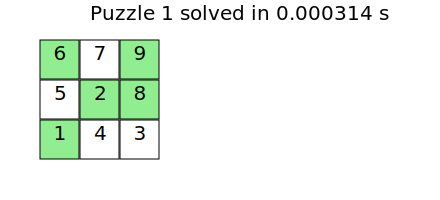

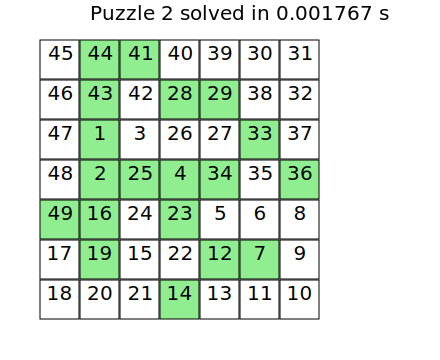

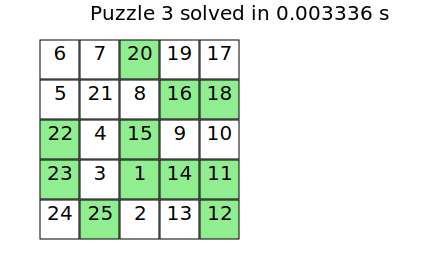

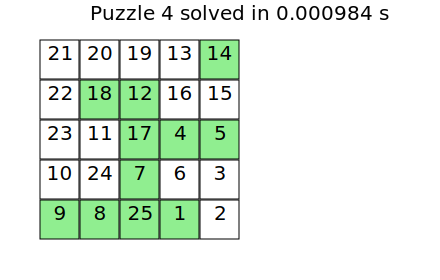

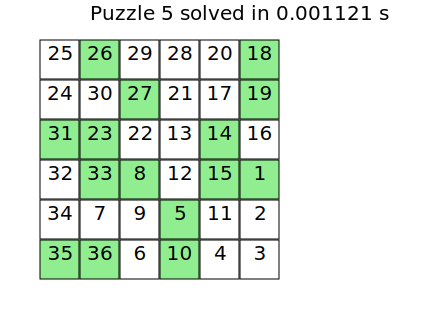

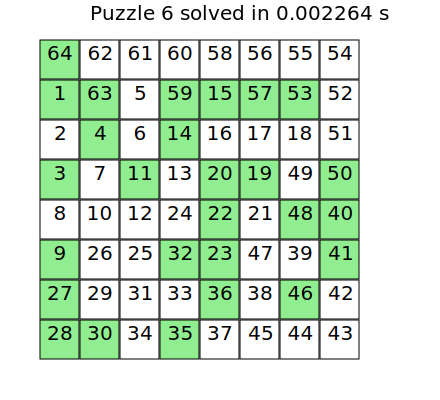

In [5]:
from ortools.sat.python import cp_model
from ortools.sat.python import visualization


def BuildPairs(rows, cols):
  """Build closeness pairs for consecutive numbers.

  Build set of allowed pairs such that two consecutive numbers touch
  each other in the grid.

  Returns:
    A list of pairs for allowed consecutive position of numbers.

  Args:
    rows: the number of rows in the grid
    cols: the number of columns in the grid
  """
  return [(x * cols + y, (x + dx) * cols + (y + dy))
          for x in range(rows) for y in range(cols)
          for dx in (-1, 0, 1) for dy in (-1, 0, 1)
          if (x + dx >= 0 and x + dx < rows and
              y + dy >= 0 and y + dy < cols and (dx != 0 or dy != 0))]


def PrintSolution(positions, rows, cols):
  """Print a current solution."""
  # Create empty board.
  board = []
  for _ in range(rows):
    board.append([0] * cols)
  # Fill board with solution value.
  for k in range(rows * cols):
    position = positions[k]
    board[position // cols][position % cols] = k + 1
  # Print the board.
  print('Solution')
  PrintMatrix(board)


def PrintMatrix(game):
  """Pretty print of a matrix."""
  rows = len(game)
  cols = len(game[0])
  for i in range(rows):
    line = ''
    for j in range(cols):
      if game[i][j] == 0:
        line += '  .'
      else:
        line += '% 3s' % game[i][j]
    print(line)


def BuildPuzzle(problem):
  #
  # models, a 0 indicates an open cell which number is not yet known.
  #
  #
  puzzle = None
  if problem == 1:
    # Simple problem
    puzzle = [[6, 0, 9],
              [0, 2, 8],
              [1, 0, 0]]

  elif problem == 2:
    puzzle = [[0, 44, 41, 0, 0, 0, 0],
              [0, 43, 0, 28, 29, 0, 0],
              [0, 1, 0, 0, 0, 33, 0],
              [0, 2, 25, 4, 34, 0, 36],
              [49, 16, 0, 23, 0, 0, 0],
              [0, 19, 0, 0, 12, 7, 0],
              [0, 0, 0, 14, 0, 0, 0]]

  elif problem == 3:
    # Problems from the book:
    # Gyora Bededek: "Hidato: 2000 Pure Logic Puzzles"
    # Problem 1 (Practice)
    puzzle = [[0, 0, 20, 0, 0],
              [0, 0, 0, 16, 18],
              [22, 0, 15, 0, 0],
              [23, 0, 1, 14, 11],
              [0, 25, 0, 0, 12]]

  elif problem == 4:
    # problem 2 (Practice)
    puzzle = [[0, 0, 0, 0, 14],
              [0, 18, 12, 0, 0],
              [0, 0, 17, 4, 5],
              [0, 0, 7, 0, 0],
              [9, 8, 25, 1, 0]]

  elif problem == 5:
    # problem 3 (Beginner)
    puzzle = [[0, 26, 0, 0, 0, 18],
              [0, 0, 27, 0, 0, 19],
              [31, 23, 0, 0, 14, 0],
              [0, 33, 8, 0, 15, 1],
              [0, 0, 0, 5, 0, 0],
              [35, 36, 0, 10, 0, 0]]
  elif problem == 6:
    # Problem 15 (Intermediate)
    puzzle = [[64, 0, 0, 0, 0, 0, 0, 0],
              [1, 63, 0, 59, 15, 57, 53, 0],
              [0, 4, 0, 14, 0, 0, 0, 0],
              [3, 0, 11, 0, 20, 19, 0, 50],
              [0, 0, 0, 0, 22, 0, 48, 40],
              [9, 0, 0, 32, 23, 0, 0, 41],
              [27, 0, 0, 0, 36, 0, 46, 0],
              [28, 30, 0, 35, 0, 0, 0, 0]]
  return puzzle


def SolveHidato(puzzle, index):
  """Solve the given hidato table."""
  # Create the model.
  model = cp_model.CpModel()

  r = len(puzzle)
  c = len(puzzle[0])

  if not visualization.RunFromIPython():
    print('')
    print('----- Solving problem %i -----' % index)
    print('')
    print(('Initial game (%i x %i)' % (r, c)))
    PrintMatrix(puzzle)

  #
  # declare variables
  #
  positions = [model.NewIntVar(0, r * c - 1, 'p[%i]' % i)
               for i in range(r * c)]

  #
  # constraints
  #
  model.AddAllDifferent(positions)

  #
  # Fill in the clues
  #
  for i in range(r):
    for j in range(c):
      if puzzle[i][j] > 0:
        model.Add(positions[puzzle[i][j] - 1] == i * c + j)

  # Consecutive numbers much touch each other in the grid.
  # We use an allowed assignment constraint to model it.
  close_tuples = BuildPairs(r, c)
  for k in range(0, r * c - 1):
    model.AddAllowedAssignments([positions[k], positions[k + 1]], close_tuples)

  #
  # solution and search
  #

  solver = cp_model.CpSolver()
  status = solver.Solve(model)

  if status == cp_model.MODEL_SAT:
    if visualization.RunFromIPython():
      output = visualization.SvgWrapper(10, r, 40.0)
      for i in range(len(positions)):
        val = solver.Value(positions[i])
        x = val % c
        y = val // c
        color = 'white' if puzzle[y][x] == 0 else 'lightgreen'
        value = solver.Value(positions[i])
        output.AddRectangle(x, r - y - 1, 1, 1, color, 'black', str(i + 1))

      output.AddTitle('Puzzle %i solved in %f s' % (index, solver.WallTime()))
      output.Display()
    else:
      PrintSolution([solver.Value(x) for x in positions], r, c,)
      print('Statistics')
      print('  - conflicts : %i' % solver.NumConflicts())
      print('  - branches  : %i' % solver.NumBranches())
      print('  - wall time : %f ms' % solver.WallTime())


def main():
  for i in range(1, 7):
    SolveHidato(BuildPuzzle(i), i)


if __name__ == '__main__':
  main()